In [1]:
import torch
import gc

def deep_clean_cuda():
    if torch.cuda.is_available():
        print(f"Current VRAM Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    
        torch.cuda.synchronize()
        gc.collect()
        gc.collect()
        torch.cuda.empty_cache()
        
        print(f"Deep clean complete. Current VRAM Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

deep_clean_cuda()

Current VRAM Allocated: 0.00 MB
Deep clean complete. Current VRAM Allocated: 0.00 MB


### Vanilla run

In [21]:
from script import run_pipeline
run_pipeline("vanilla")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/372 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /home/shay-lavi/.cache/huggingface/hub/models--sd2-community--stable-diffusion-2-base/snapshots/f5bc1bd97485577aa0b946fa8a9004e2ec147402/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Processing shay.jpg...


  0%|          | 0/50 [00:00<?, ?it/s]

Processing cat.jpg...


  0%|          | 0/50 [00:00<?, ?it/s]

Processing cat.out.jpg...


  0%|          | 0/50 [00:00<?, ?it/s]

### Generate using diffusion model

In [2]:
# Use the Euler scheduler here instead
scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

/home/shay-lavi/miniconda3/envs/proj/lib/python3.11/site-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/372 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /home/shay-lavi/.cache/huggingface/hub/models--sd2-community--stable-diffusion-2-base/snapshots/f5bc1bd97485577aa0b946fa8a9004e2ec147402/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [6]:
prompt = "a funny meme"
image = pipe(prompt).images[0]  

image.save(f'generations/{prompt.replace(" ", "_")}.png')

  0%|          | 0/50 [00:00<?, ?it/s]

### RePaint

In [1]:
import torch
import requests
from io import BytesIO
from PIL import Image, ImageOps, ImageDraw

from VanillaPipeline import VanillaPipeline
from diffusers import DDPMScheduler

model_id = "sd2-community/stable-diffusion-2-base"

scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = VanillaPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")


/home/shay-lavi/miniconda3/envs/proj/lib/python3.11/site-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/372 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /home/shay-lavi/.cache/huggingface/hub/models--sd2-community--stable-diffusion-2-base/snapshots/f5bc1bd97485577aa0b946fa8a9004e2ec147402/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


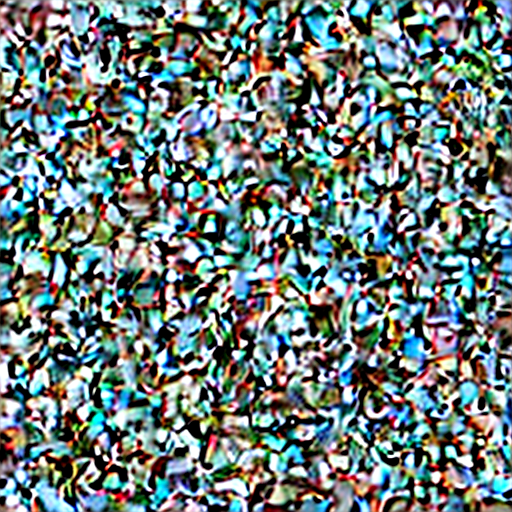

Step 0 | timestep 981


NameError: name 'axes' is not defined

In [2]:
from mask_utils import get_square, overlay_mask, get_grid, create_comparison_canvas
from script import read_file
from interactive import make_callback

image = Image.open("media/cat.jpg")
mask = Image.open("media/cat.mask.jpg")
prompt = read_file("media/cat.txt")
interactive_mode = True

kwargs = {
    "callback": make_callback(pipe, display_every_n_steps=1),
    "callback_steps": 1,
} if interactive_mode else {}

output = pipe(
    prompt=prompt,
    num_inference_steps=50,
    image=image,
    mask=mask,
    guidance_scale=7.5,
    **kwargs
)

result = output.images[0]

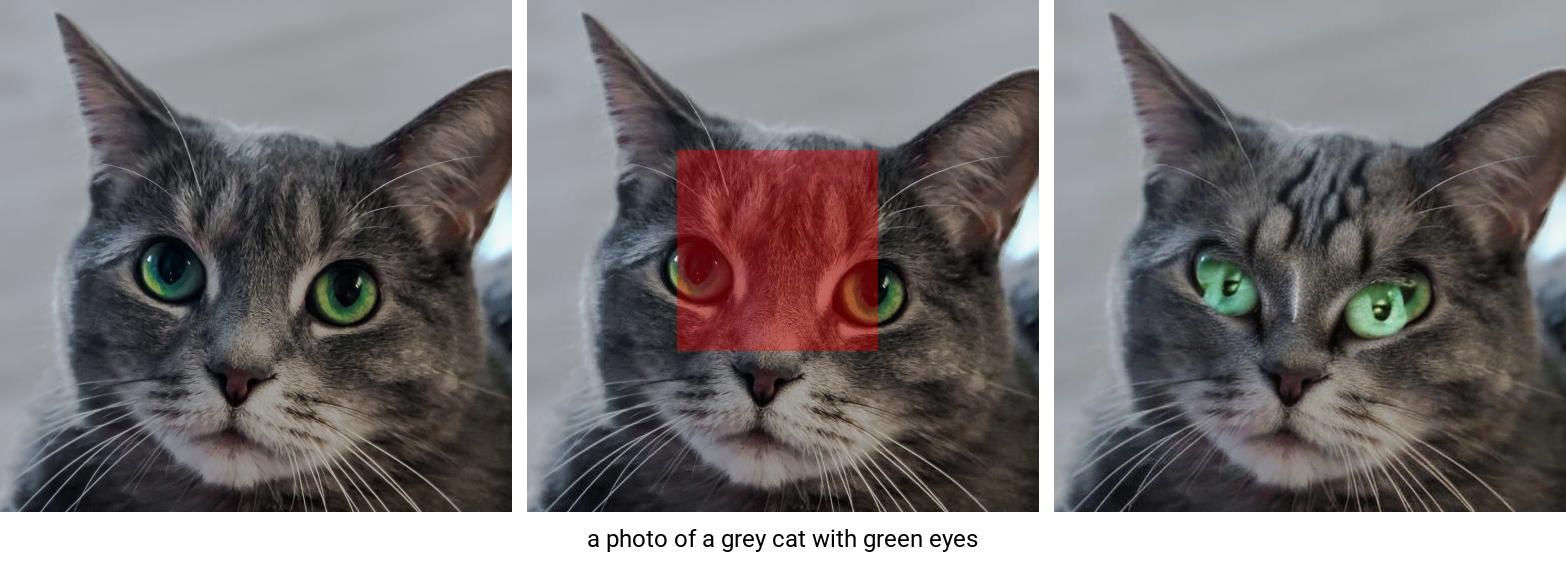

In [3]:
final_strip = create_comparison_canvas(
    image, 
    mask, result,text_label=prompt, alpha=0.35
)

final_strip.show()
final_strip.convert('RGB').save("results/cat.jpg")